In [1]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_csv("data/MSFT-1Y-Hourly.csv")

<IPython.core.display.Javascript object>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753 entries, 0 to 1752
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1753 non-null   object 
 1   open      1753 non-null   float64
 2   high      1753 non-null   float64
 3   low       1753 non-null   float64
 4   close     1753 non-null   float64
 5   volume    1753 non-null   int64  
 6   average   1753 non-null   float64
 7   barCount  1753 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 109.7+ KB


<IPython.core.display.Javascript object>

In [4]:
df.set_index("date", drop=True, inplace=True)

<IPython.core.display.Javascript object>

We'll use only the close feature.

In [5]:
df = df[["close"]]

<IPython.core.display.Javascript object>

In [6]:
type(df["close"]) == type(df[["close"]])

False

<IPython.core.display.Javascript object>

In [7]:
type(df[["close"]])

pandas.core.frame.DataFrame

<IPython.core.display.Javascript object>

In [8]:
df.describe()

,close
count,1753.000000
mean,164.330610
std,23.125225
min,132.670000
25%,143.320000
50%,159.750000
75%,183.390000
max,216.540000


<IPython.core.display.Javascript object>

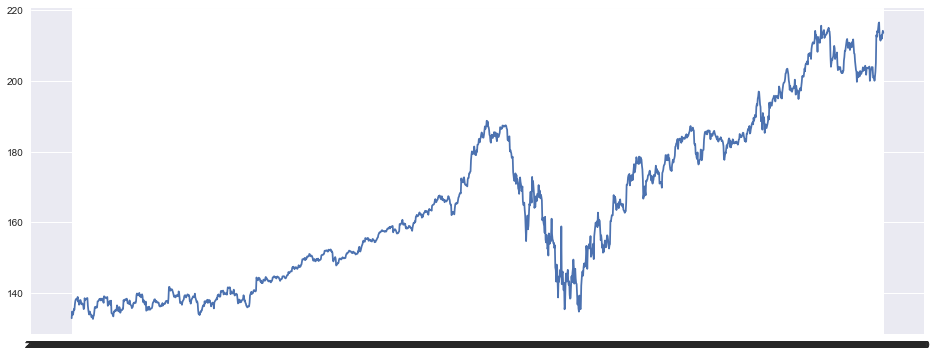

<IPython.core.display.Javascript object>

In [9]:
plt.figure(1, figsize=(16, 6))
_ = plt.plot(df.close)

Calculate the percentage change.

The reason for using pct_change instead of the prices is the benefit of normalization as we can measure all variables in a comparable metric. Also returns have more manageable statistical properties than prices such as stationarity, as in most cases we don't have stationary prices but we can have stationary returns.

A stationary time series is one where statistical properties such as mean, variance, correlation, etc are constant over time.
For more details on stationarity: https://en.wikipedia.org/wiki/Stationary_process

In [10]:
df["returns"] = df.close.pct_change()

<IPython.core.display.Javascript object>

In [11]:
df.head(5)

,close,returns
date,,
2019-08-07 14:30:00,132.89,NaN
2019-08-07 15:00:00,134.75,0.013997
2019-08-07 16:00:00,133.88,-0.006456
2019-08-07 17:00:00,133.90,0.000149
2019-08-07 18:00:00,134.83,0.006945


<IPython.core.display.Javascript object>

In [12]:
134.75 / 132.89 - 1

0.013996538490480992

<IPython.core.display.Javascript object>

Calculate the log returns.

Why use log returns: https://quantivity.wordpress.com/2011/02/21/why-log-returns/

In [13]:
df["log_returns"] = np.log(1 + df["returns"])

<IPython.core.display.Javascript object>

In [14]:
df.head(5)

,close,returns,log_returns
date,,,
2019-08-07 14:30:00,132.89,NaN,NaN
2019-08-07 15:00:00,134.75,0.013997,0.013899
2019-08-07 16:00:00,133.88,-0.006456,-0.006477
2019-08-07 17:00:00,133.90,0.000149,0.000149
2019-08-07 18:00:00,134.83,0.006945,0.006921


<IPython.core.display.Javascript object>

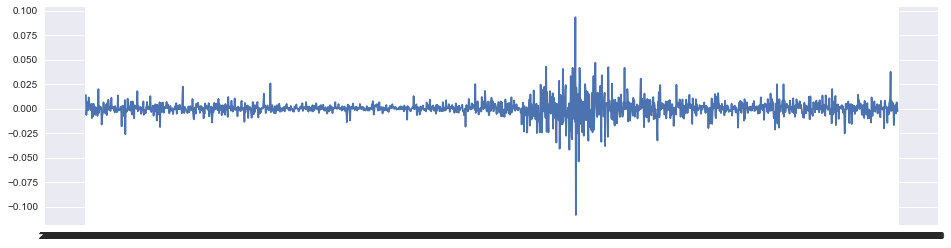

<IPython.core.display.Javascript object>

In [15]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.log_returns)

In [16]:
df.dropna(inplace=True)
X = df[["close", "log_returns"]].values

<IPython.core.display.Javascript object>

In [17]:
X

array([[ 1.34750000e+02,  1.38994914e-02],
       [ 1.33880000e+02, -6.47733345e-03],
       [ 1.33900000e+02,  1.49376354e-04],
       ...,
       [ 2.13350000e+02,  6.48925441e-03],
       [ 2.14190000e+02,  3.92946195e-03],
       [ 2.13640000e+02, -2.57111611e-03]])

<IPython.core.display.Javascript object>

In [18]:
from sklearn.preprocessing import MinMaxScaler

<IPython.core.display.Javascript object>

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

<IPython.core.display.Javascript object>

In [20]:
X_scaled[:5]

array([[0.02480029, 0.6063657 ],
       [0.01442709, 0.50534309],
       [0.01466555, 0.53819647],
       [0.02575414, 0.57177063],
       [0.03350423, 0.56129908]])

<IPython.core.display.Javascript object>

In [21]:
y = [x[0] for x in X_scaled]

<IPython.core.display.Javascript object>

In [22]:
y[:5]

[0.024800286157148133,
 0.014427089543340932,
 0.014665553833313805,
 0.025754143317038736,
 0.033504232741147]

<IPython.core.display.Javascript object>

#### Train test split

In [23]:
split = int(len(X_scaled) * 0.8)
print(split)

1401


<IPython.core.display.Javascript object>

In [24]:
X_train = X_scaled[:split]
X_test = X_scaled[split : len(X_scaled)]
y_train = y[:split]
y_test = y[split : len(y)]

<IPython.core.display.Javascript object>

In [25]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

<IPython.core.display.Javascript object>

#### Labeling

We want to predict the stock price at a future time. We'll predict the stock price at time t + 1 relative to the stock price at time t.

As we're going to use an LSTM architecture, we know that it has memory and that it is maintained by setting the time step, basically how many steps in the past we want the LSTM to use.

The time step  refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for weight updates during training.

So we can use a method to create both the timestep and the output variable, the t + 1.

In [26]:
n = 3
Xtrain = []
ytrain = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i])  # predict next record
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i])  # predict next record

<IPython.core.display.Javascript object>

In [27]:
df.head(5)

,close,returns,log_returns
date,,,
2019-08-07 15:00:00,134.75,0.013997,0.013899
2019-08-07 16:00:00,133.88,-0.006456,-0.006477
2019-08-07 17:00:00,133.90,0.000149,0.000149
2019-08-07 18:00:00,134.83,0.006945,0.006921
2019-08-07 19:00:00,135.48,0.004821,0.004809


<IPython.core.display.Javascript object>

In [28]:
Xtrain[0]

array([[0.02480029, 0.6063657 ],
       [0.01442709, 0.50534309],
       [0.01466555, 0.53819647]])

<IPython.core.display.Javascript object>

In [29]:
ytrain[0]

0.025754143317038736

<IPython.core.display.Javascript object>

In [30]:
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape)]

<IPython.core.display.Javascript object>

In [31]:
scaler.inverse_transform(val)

array([[ 1.34830000e+02, -1.08407857e-01]])

<IPython.core.display.Javascript object>

In an LSTM network the input for each LSTM layer needs to contain the following information:
- The number of observations
- The time steps
- The features

Therefore we need to add a temporal dimension compared to a classical network:

(number of observations, number of steps, number of features per step)

In [32]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

<IPython.core.display.Javascript object>

In [33]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

(1398, 3, 2)
(1398,)
---
(348, 3, 2)
(348,)


<IPython.core.display.Javascript object>

#### LSTM Model

In [44]:
# pip install tensorflow

<IPython.core.display.Javascript object>

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

<IPython.core.display.Javascript object>

In [36]:
model = Sequential()
model.add(LSTM(4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(
    Xtrain, ytrain, epochs=100, validation_data=(Xtest, ytest), batch_size=16, verbose=1
)

Epoch 1/100
88/88 [==============================] - 4s 11ms/step - loss: 0.0425 - val_loss: 0.1169
Epoch 2/100
88/88 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0489
Epoch 3/100
88/88 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0091
Epoch 4/100
88/88 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 6.7900e-04
Epoch 5/100
88/88 [==============================] - 0s 3ms/step - loss: 4.8461e-04 - val_loss: 6.0684e-04
Epoch 6/100
88/88 [==============================] - 0s 3ms/step - loss: 4.3431e-04 - val_loss: 6.4236e-04
Epoch 7/100
88/88 [==============================] - 0s 3ms/step - loss: 4.2673e-04 - val_loss: 6.2420e-04
Epoch 8/100
88/88 [==============================] - 0s 3ms/step - loss: 4.1804e-04 - val_loss: 4.8517e-04
Epoch 9/100
88/88 [==============================] - 0s 3ms/step - loss: 4.1692e-04 - val_loss: 4.2224e-04
Epoch 10/100
88/88 [==============================] - 0s 3ms/ste

Epoch 79/100
88/88 [==============================] - 0s 3ms/step - loss: 2.8699e-04 - val_loss: 0.0010
Epoch 80/100
88/88 [==============================] - 0s 3ms/step - loss: 2.7249e-04 - val_loss: 8.7809e-04
Epoch 81/100
88/88 [==============================] - 0s 2ms/step - loss: 2.6920e-04 - val_loss: 0.0011
Epoch 82/100
88/88 [==============================] - 0s 3ms/step - loss: 2.7747e-04 - val_loss: 8.9895e-04
Epoch 83/100
88/88 [==============================] - 0s 3ms/step - loss: 2.7841e-04 - val_loss: 8.5026e-04
Epoch 84/100
88/88 [==============================] - 0s 3ms/step - loss: 2.7191e-04 - val_loss: 8.5883e-04
Epoch 85/100
88/88 [==============================] - 0s 2ms/step - loss: 2.7119e-04 - val_loss: 9.4700e-04
Epoch 86/100
88/88 [==============================] - 0s 3ms/step - loss: 2.7452e-04 - val_loss: 0.0010
Epoch 87/100
88/88 [==============================] - 0s 3ms/step - loss: 2.7116e-04 - val_loss: 0.0013
Epoch 88/100
88/88 [========================

<IPython.core.display.Javascript object>

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 112       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [38]:
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)



11/11 [==============================] - 0s 1ms/step


<IPython.core.display.Javascript object>

In [39]:
trainPredict = np.c_[trainPredict, np.zeros(trainPredict.shape)]
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

<IPython.core.display.Javascript object>

In [40]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = [x[0] for x in trainPredict]

testPredict = scaler.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]


<IPython.core.display.Javascript object>

In [41]:
print(trainPredict[:5])
print(testPredict[:5])

[134.65317274438215, 134.96540694369003, 135.59994044382123, 135.7236564118415, 136.8624724470079]
[182.74680401027203, 182.56819825351238, 182.29574049055577, 181.45598149359228, 178.68374300181867]


<IPython.core.display.Javascript object>

In [42]:
from sklearn.metrics import mean_squared_error

<IPython.core.display.Javascript object>

In [43]:
# calculate root mean squared error
trainScore = mean_squared_error([x[0][0] for x in Xtrain], trainPredict, squared=False)
print("Train Score: %.2f RMSE" % (trainScore))

testScore = mean_squared_error([x[0][0] for x in Xtest], testPredict, squared=False)
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 156.20 RMSE
Test Score: 196.04 RMSE


<IPython.core.display.Javascript object>